In [1]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/char_transformer

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZdikWibndOy-EAHWOwKrJSalwWRmsckp/char_transformer


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
from models.lstm import LSTM
import util.generation as generation


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [5]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [6]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [7]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [8]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

 to obtain help from ouaddai in putting down internal dissension when the capital was burned in one eight nine three the sultan 

nsidered a seminal culinary work upon this success mrs child wrote magazine articles and a regular column for the boston globe n

lopment or structure in optics the word has two special applications four one aberration of light also referred to as astronomic

 however he fell from public favor after the cancellation of diff rent strokes his acting career declined sharply in one nine ni

netherlands is named the spinozapremie spinoza reward quotes mind and body are one and the same individual which is conceived no



# Create a basic LSTM model

In [9]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6):
    # create a basic LSTM model
    model = LSTM(vocab_size, d_model, n_layers)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, 32), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [10]:
# vocab size
vocab_size= len(char_set)
'''

# internal model dimensions
d_model=256

# number of LSTM layers
n_layers=

# maximum sequence length
max_len=128

model, params = create_train_state(key, vocab_size, d_model, n_layers, max_len)
'''
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
'''
print(f"Number of parameters: {count_params(params):_}")

# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)
'''

'\nprint(f"Number of parameters: {count_params(params):_}")\n\n# sanity check: create a batch of data & run a forward pass\nB, T = 4, 32\nbatch = jax.random.randint(\n    key=key,\n    shape=(B, T), minval=0, maxval=len(char_set))\nlogits = model.apply({"params": params}, batch)\n\nprint("batch shape:", batch.shape)  # (B, T)\nprint("logits shape:", logits.shape)  # (B, T, vocab_size)\n'

# Loss function

In [11]:
@jax.jit
def loss_and_metrics(logits, targets, gamma=2.0, alpha = 0.25):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [12]:
'''
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))
'''

'\n# create an update function\ndef train_step(params, opt_state, x, y, tx):\n    """Single optimization step using optax optimizer.\n\n    Args:\n      params: pytree of model parameters.\n      opt_state: optax optimizer state corresponding to `params`.\n      x: (B, T) int array input tokens.\n      y: (B, T) int array target tokens.\n      tx: optax.GradientTransformation (already initialized).\n\n    Returns:\n      new_params: updated parameters after one gradient step.\n      new_opt_state: updated optimizer state.\n      metrics: dict of scalar metrics (loss, acc).\n    """\n    def loss_fn(params):\n        logits = model.apply({"params": params}, x)\n        loss, metrics = loss_and_metrics(logits, y)\n        return loss, metrics\n\n    # compute gradients (loss is scalar, metrics is auxiliary)\n    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)\n\n    # optax update: compute parameter updates and new optimizer state\n    updates, new_opt_state = 

# Batch creation:

In [13]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# New testing

In [14]:
import gc

In [15]:
# Define multiple architectures to test quickly
architectures = [{"d_model": 128, "n_layers": n} for n in range(2, 9, 2)] + [
    {"d_model": 256, "n_layers": 2},
    {"d_model": 256, "n_layers": 4},
    {"d_model": 384, "n_layers": 2}
]

In [16]:
def architecture_sweep(architectures, train_time_minutes=5):
    results = {}
    for i in range(len(architectures) - 1, -1, -1):
        """Test architecture for 5 minutes and return validation loss"""
        # Initialize model and optimizer inside the function for each test
        arch_config = architectures[i]
        print(f"\nTesting architecture: {arch_config}")

        model, params = create_train_state(key, vocab_size, **arch_config)
        print(f"Number of parameters: {count_params(params):_}")
        tx = optax.adam(learning_rate=0.001)
        opt_state = tx.init(params)
        B, T = 64, 32  # Small batch for quick testing

        def train_step(params, opt_state, x, y, tx):
            def loss_fn(p):
                logits = model.apply({"params":p}, x)
                loss, metrics = loss_and_metrics(logits, y)
                del logits
                return loss, metrics
            (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
            updates, new_opt_state = tx.update(grads, opt_state, params)
            new_params = optax.apply_updates(params, updates)
            return new_params, new_opt_state, metrics
        train_step = jax.jit(train_step, static_argnames=("tx",))
        start_time = time.time()
        max_time = train_time_minutes * 60  # 5 minutes in seconds
        best_val_loss = float('inf')
        patience_counter = 0


        it = 0 # Initialize iteration counter
        while time.time() - start_time < max_time:
            # Training step
            batch = get_batch(train_text_int, B, T)
            params, opt_state, metrics = train_step(params, opt_state, *batch, tx)
            it += 1 # Increment iteration counter

            # Quick validation every N steps
            if it % 50 == 0:
                val_batch = get_batch(train_text_int, 256, T)
                val_logits = model.apply({"params": params}, val_batch[0])
                val_loss, _ = loss_and_metrics(val_logits, val_batch[1])
                if val_loss < best_val_loss - 1e-5:
                  best_val_loss = val_loss
                  patience_counter = 0
                else:
                  patience_counter += 1
                  if patience_counter == 10:
                    print(f"Iteration terminated after {it} iterations at {time.time() - start_time}s.")
                    break
        print(f"Best validation loss: {best_val_loss}")
        results[tuple(arch_config.items())] = best_val_loss
        del model, params, opt_state, tx, batch, val_batch, val_logits
        gc.collect()
    return results


In [17]:
architecture_results = architecture_sweep(architectures)

# Select best architecture
best_arch, best_loss = min(architecture_results.items(), key=lambda x: x[1])
print(f"Best architecture: {best_arch} with loss {best_loss:.4f}")



Testing architecture: {'d_model': 384, 'n_layers': 2}
Number of parameters: 2_383_131
Iteration terminated after 2000 iterations at 25.72473907470703s.
Best validation loss: 1.4210150241851807

Testing architecture: {'d_model': 256, 'n_layers': 4}
Number of parameters: 2_115_099
Iteration terminated after 4300 iterations at 73.24475646018982s.
Best validation loss: 1.4158878326416016

Testing architecture: {'d_model': 256, 'n_layers': 2}
Number of parameters: 1_064_475
Iteration terminated after 3550 iterations at 29.712796211242676s.
Best validation loss: 1.3970671892166138

Testing architecture: {'d_model': 128, 'n_layers': 8}
Number of parameters: 1_059_611
Iteration terminated after 6550 iterations at 213.84198117256165s.
Best validation loss: 1.6406283378601074

Testing architecture: {'d_model': 128, 'n_layers': 6}
Number of parameters: 796_443
Iteration terminated after 3700 iterations at 96.15184092521667s.
Best validation loss: 1.7893091440200806

Testing architecture: {'d_mod

In [32]:
d_model, n_layers = best_arch
d_model = d_model[1]
n_layers = 4
model, params = create_train_state(key, vocab_size, d_model, n_layers)
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Optimizer creation:

In [33]:
# define optax optimizer
# learning_rate = 0.001
# Create Adam optimizer (Optax)
tx = optax.adamw(
    learning_rate=optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=5e-3,
        warmup_steps=2000,
        decay_steps=98000,
        end_value=0.0
    ),
    weight_decay=1e-4,
)

# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: {tx}")



Initialized optimizer: GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7a625895af20>, update=<function chain.<locals>.update_fn at 0x7a6258958400>)


In [34]:
niter = 100_000
B = 128
T = 32
loss_history = []
time_history = []
best_val_loss = float('inf')
highest_test_accuracy = float(0)
highest_last_test = float(0)
time_test_history = []
loss_test_history = []
test_accuracy_history = []
last_test_accuracy_history = []
time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
      time_test_history.append(time.time() - time_start)

      time_since_start = time.time() - time_start
      # compute loss on test set
      B_test, T_test = 1024, 32
      test_batch = get_batch(test_text_int, B_test, T_test)
      test_input, test_target = test_batch[0], test_batch[1]
      test_logits = model.apply({"params": params}, test_input)
      test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
      test_acc = test_metrics['acc']
      test_acc_last = test_metrics['acc_last']
      loss_test_history.append(test_loss)
      best_val_loss = min(best_val_loss, test_loss)
      highest_test_accuracy = max(highest_test_accuracy, test_acc)
      highest_last_test = max(highest_last_test, test_acc_last)
      test_accuracy_history.append(test_acc)
      last_test_accuracy_history.append(test_acc_last)
      print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
      print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
      print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
      print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
      print()

print(f"Best validation loss: {best_val_loss}")
print(f"Best test accuracy: {highest_test_accuracy}")
print(f"Best last character test accuracy: {highest_last_test}")

iteration 0  time: 23.6 seconds
	 	 loss(train :: test): 3.2959 :: 3.2959
	 	 accuracy (train :: test): 3.4% :: 3.9%
	 	 accuracy (last character) (train :: test): 1.6% :: 5.1%

iteration 2_000  time: 26.4 seconds
	 	 loss(train :: test): 1.4909 :: 1.4797
	 	 accuracy (train :: test): 53.8% :: 54.6%
	 	 accuracy (last character) (train :: test): 53.1% :: 57.6%

iteration 4_000  time: 28.9 seconds
	 	 loss(train :: test): 1.3854 :: 1.4402
	 	 accuracy (train :: test): 57.0% :: 55.2%
	 	 accuracy (last character) (train :: test): 60.9% :: 55.2%

iteration 6_000  time: 31.3 seconds
	 	 loss(train :: test): 1.3934 :: 1.4217
	 	 accuracy (train :: test): 56.3% :: 55.5%
	 	 accuracy (last character) (train :: test): 53.9% :: 57.3%

iteration 8_000  time: 34.0 seconds
	 	 loss(train :: test): 1.3825 :: 1.4351
	 	 accuracy (train :: test): 56.3% :: 55.3%
	 	 accuracy (last character) (train :: test): 52.3% :: 58.6%

iteration 10_000  time: 36.4 seconds
	 	 loss(train :: test): 1.4329 :: 1.4334

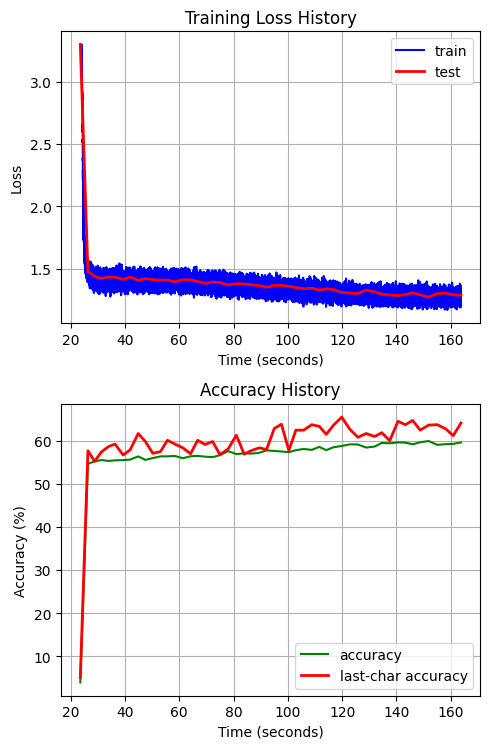

In [45]:
# plot the loss history
import matplotlib.pyplot as plt

plt.figure(figsize=(5,8))

plt.subplot(2,1,1)
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

plt.subplot(2,1,2)
plt.plot(time_test_history, list(map(lambda x: x * 100, test_accuracy_history)), '-', label='accuracy', color="green")
plt.plot(time_test_history, list(map(lambda x: x * 100, last_test_accuracy_history)), '-', label='last-char accuracy', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy (%)")
plt.legend(loc='lower right')
plt.title(f"Accuracy History")
plt.grid()

# ---- Shared title ----
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve 5% at top for suptitle
#plt.suptitle(f"Training Metrics — d_model: {d_model}, n_layers: {n_layers}, optimizer=cosine decay, B&T=({B}, {T})", fontsize=14)

plt.savefig(f'assets/lstm_{d_model}_{n_layers}.png', bbox_inches='tight', dpi=300)
plt.show()

In [37]:
import csv

train_file_name = f"./data/lstm/train_loss_{d_model}_{n_layers}.csv"
with open(train_file_name, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["time", "loss"])  # header
    writer.writerows(zip(time_history, loss_history))

test_file_name = f"./data/lstm/test_loss_{d_model}_{n_layers}.csv"
# Test metrics
with open(test_file_name, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["time", "loss", "accuracy", "last character accuracy"])  # header
    writer.writerows(zip(time_test_history, loss_test_history, test_accuracy_history, last_test_accuracy_history))

print("csv files saved:", train_file_name, test_file_name)

csv files saved: ./data/lstm/train_loss_256_4.csv ./data/lstm/test_loss_256_4.csv


In [ ]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
#print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))